---
<h2 align='center'> Model Training </h2>

---

<h3> Contents </h3>

1. Data Transformation
2. Model Training
3. Model Selection

---

<h3> Importing important libraries <h3>

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Imports for data transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn import set_config

# Imports for modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

---

<h3> Importing dataset using pandas library </h3>

In [3]:
df = pd.read_csv('D:\Bengaluru_Restaurant_Price_Predictor\notebook\data\zomato.csv')

---

<h3> Taking a quick look at the dataset </h3>

In [4]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


From the table it can be observed that the dataset has been imported properly.

---

<h2 align='center'> 1. Data Transformation </h2>

<h3> This phase follows following process: </h3>


* **Splitting** the dataset into train and test
* Creating **function** for **transformation**
* Creating **column transformers**
* Chaining all the processes using **pipeline**

---

<h3> 1.1 Splitting the dataset into train and test

In [5]:
# Splitting the dataset into train and test
train, test = train_test_split(df, test_size=0.20, random_state=9)

Data has been split into training and testing data.

---

<h3> Setting global configurations </h3>

In [6]:
# Setting global configurations
set_config(display='diagram', transform_output="pandas")

Now the pipeline can be displayed as a diagram and the output will be a pandas DataFrame instead of numpy array.

---

<h3> 1.2 Important functions for transformation

In [7]:
# Functions for data transformation

# Function for important preprocessing
def preprocess(df):
  """ 
  This function drop rows with NULL values in columns
  'approx_cost(for two people)' and 'rest_type'. Then
  the dataset is exploded by 'rest_type.
  
  """
  # Dropping rows where price or rest_type in NULL
  df = df[df['approx_cost(for two people)'].notna()]
  df = df[df['rest_type'].notna()]

  # Splitting clustered values in rest_type
  df['rest_type'] = df['rest_type'].apply(lambda x: str(x).split(','))
  df = df.explode('rest_type')

  # Dropping duplicates
  df.drop_duplicates(inplace=True)

  return df


# Function to preprocess feature rate
def prep_rate(df):
  """
  This function changes values 'NEW', '-', 'nan' to 0 and
  converts feature 'rate' to float type.

  """
  df['rate'].replace(['NEW', '-', np.nan], 0.0, inplace=True)
  df['rate'] = df['rate'].apply(lambda x: float(str(x)[:3]))

  return df


# Function to split features and target variable
def X_y_split(df):
  """
  This function splits features and target variable into
  X and y and converts target variable into float type.
  
  """
  X = df.drop('approx_cost(for two people)', axis=1)
  y = df['approx_cost(for two people)']

  # Converting 'approx_cost(for two people)' to float
  y = y.apply(lambda x: float(str(x).replace(',','')))

  return X,y

Conclusion:
* `preprocess()` will remove NULL values from `price` and `type_tag` (`rest_type`), it will also split rows by `type_tag` and finally drop duplicates from the dataset.

* `prep_rate()` will convert `rate` column to float type

* `X_y_split()` split feature variables and target variable (`approx_cost(for two people)`) and converts target variable to float type.
---

<h3> 1.3 Column Transformers for data transformation </h3>

In [8]:
# Transformer to select important features
select_trf = ColumnTransformer(transformers=[
    ("SelectColumns", 'passthrough', ['online_order',
                                      'book_table',
                                      'rate',
                                      'votes',
                                      'location',
                                      'rest_type',
                                      'approx_cost(for two people)',
                                      'listed_in(type)'])
], verbose_feature_names_out=False)


# Transformer to do necessary preprocessing
pre_trf = ColumnTransformer(transformers=[
    ("Preprocess", FunctionTransformer(preprocess), slice(0,8))
], verbose_feature_names_out=False)


# Transformer to preprocess 'rate' column
pre_rate_trf = ColumnTransformer(transformers=[
    ("PreprocessRate", FunctionTransformer(prep_rate), slice(0,8))
], verbose_feature_names_out=False)


# Transformer to impute 'rate' column
imp_rate_trf = ColumnTransformer(transformers=[
    ("SimpleImputer", SimpleImputer(missing_values=0.0, strategy="mean"), ['rate'])
], remainder = 'passthrough', verbose_feature_names_out=False)


# Transformer to Ordinal Encode columns
encode_trf = ColumnTransformer(transformers=[
    ("OrdinalEncoder", OrdinalEncoder(), ['online_order',
                                          'book_table',
                                          'location',
                                          'rest_type',
                                          'listed_in(type)'])
], remainder = 'passthrough', verbose_feature_names_out=False)


# Transformer to MinMax scale columns
scale_trf = ColumnTransformer(transformers=[
    ("MinMaxScaler", MinMaxScaler(), ['location',
                                      'rest_type',
                                      'votes'])
], remainder = 'passthrough', verbose_feature_names_out=False)

Conclusion:

* `select_trf`: This transformer selects important columns from the dataset, drop the rest.

* `pre_trf`: This transformer preprocesses the dataset using `preprocess()`

* `pre_rate_trf`: This transformer preprocesses `rate` column using `prep_rate()`

* `imp_rate_trf`: This transformer uses `SimpleImputer()` to impute `rate` column using mean as strategy

* `encode_trf`: This transformer uses `OrdinalEncoder()` to encode columns `online_order`, `book_table`, `location`, `rest_type`, `listed_in(type)`

* `scale_trf`: This transformer scales columns `location`, `rest_type`, `votes`
---

<h3> 1.4 Pipeline for transformation </h3>

In [9]:
# Pipeline to chain all the transformers
pipe = Pipeline(steps = [
    ("select_trf", select_trf),
    ("pre_trf", pre_trf),
    ("pre_rate_trf", pre_rate_trf),
    ("imp_rate_trf", imp_rate_trf),
    ("ord_encd_trf", encode_trf),
    ("scaler_trf", scale_trf),
    ("split_trf", FunctionTransformer(X_y_split))
])

pipe

Pipeline(steps=[('select_trf',
                 ColumnTransformer(transformers=[('SelectColumns',
                                                  'passthrough',
                                                  ['online_order', 'book_table',
                                                   'rate', 'votes', 'location',
                                                   'rest_type',
                                                   'approx_cost(for two '
                                                   'people)',
                                                   'listed_in(type)'])],
                                   verbose_feature_names_out=False)),
                ('pre_trf',
                 ColumnTransformer(transformers=[('Preprocess',
                                                  FunctionTransformer(func=<function preprocess at 0x...
                                                  ['online_order', 'book_table',
                                                   'location', 'rest_type',
                                                   'listed_in(type)'])],
                                   verbose_feature_names_out=False)),
                ('scaler_trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('MinMaxScaler',
                                                  MinMaxScaler(),
                                                  ['location', 'rest_type',
                                                   'votes'])],
                                   verbose_feature_names_out=False)),
                ('split_trf',
                 FunctionTransformer(func=<function X_y_split at 0x7f88e27e5750>))])

This pipeline chains all the ColumnTransformers together and finally chains `X_y_split()` and return X and y datasets.

---

<h2 align='center'> 2. Model Training </h2>

<h3> This phase follows the following approach: </h3>

* **Fitting** the datasets to **pipeline**
* Model **training** and **prediction**

---

<h3> 2.1 Fit pipeline and split features and target variable </h3>

In [10]:
# Function to create train-test X,y splits  
def train_test(train, test):
  X_train, y_train = pipe.fit_transform(train)
  X_test, y_test = pipe.transform(test)

  X_train.to_numpy()
  X_test.to_numpy()
  y_train.to_numpy()
  y_test.to_numpy()

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test(train, test)

`test_train()` fits the pipeline to the train and test dataset and splits features and target variable into `X` and `y`

---

<h3> Function to evaluate models </h3>

In [11]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

`evaluate_model()` evaluates the following metrics of the model:
* mean absolute error
* mean squared error
* root mean square error
* $r^2$ score

---

<h3> 2.2 Model training and prediction </h3>

In [12]:
models = {
    "SVR": SVR(),
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

SVR
Model performance for Training set
- Root Mean Squared Error: 372.2187
- Mean Absolute Error: 230.3210
- R2 Score: 0.4269
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 360.3457
- Mean Absolute Error: 224.1597
- R2 Score: 0.4250


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 346.6570
- Mean Absolute Error: 233.1900
- R2 Score: 0.5029
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 339.1222
- Mean Absolute Error: 228.1402
- R2 Score: 0.4908


Lasso
Model performance for Training set
- Root Mean Squared Error: 347.1084
- Mean Absolute Error: 233.9898
- R2 Score: 0.5016
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 339.4091
- Mean Absolute Error: 228.9176
- R2 Score: 0.4899


Ridge
Model performance for Training set
- Root Mean Squared Error: 346.6573
- Mean Absolute Error: 233.2150
- R2 Score: 0.5029
-------------

Training multiple models and evaluating their performance, $r2$ score being the primary indicator of model performance 

---

<h2 align='center'> 3. Model Selection </h2>

<h3> This phase follows the following approach: </h3>

* **Listing** models by **performance**
* Calculating model **accuracy**
* **Scatterplot** of actual vs predicted values
* **Regressionplot** of acutal vs predicted values

---

<h3> 3.1 List of model performance </h3>

In [13]:
pd.DataFrame(list(zip(model_list, r2_list)), 
             columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],
                                                             ascending=False)

,Model Name,R2_Score
6,Random Forest Regressor,0.942315
5,Decision Tree,0.917353
7,XGBRegressor,0.881908
8,CatBoosting Regressor,0.864653
4,K-Neighbors Regressor,0.780266
3,Ridge,0.490775
1,Linear Regression,0.490759
2,Lasso,0.489897
9,AdaBoost Regressor,0.449209
0,SVR,0.425024


From the results it can be observed that tree based models are doing well due to large amount of categorical data in the dataset.

---

<h3> 3.2 Calculating the accuracy of best model </h3>

In [14]:
rfr_model = RandomForestRegressor()
rfr_model = rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 94.20


Model has good accuracy.

---

<h3> 3.3 Scatter plot of actual vs predicted values </h3>

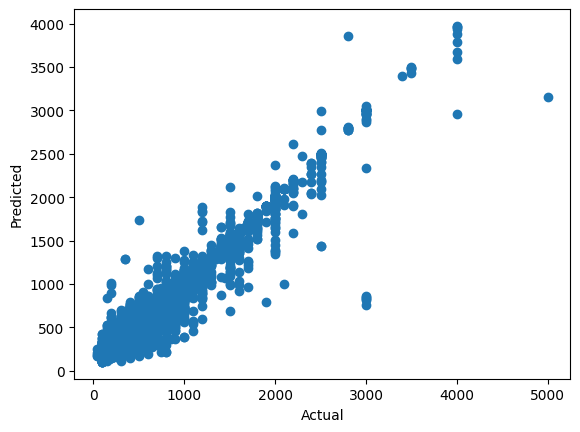

In [15]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

Apart from some outliers, model prediction is good.

---

<h3> 3.4 Regression plot of acutal vs predicted values </h3>

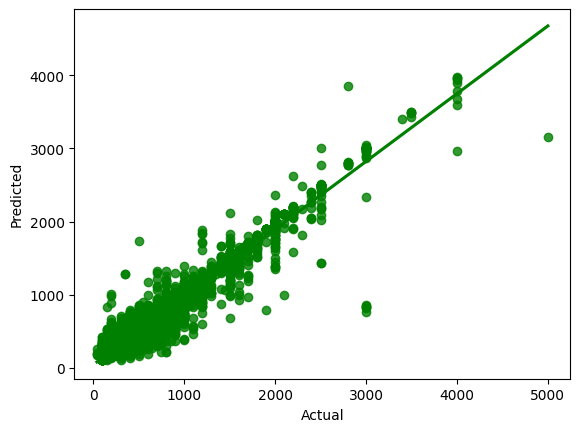

In [16]:
sns.regplot(x=y_test,
            y=y_pred,
            ci=None,
            color ='green');
plt.xlabel('Actual');
plt.ylabel('Predicted');

---
---